### Libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsaplots
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import random

### Thoughts on Strategy Employed
<ol>
    <li>The problem requires prediction for a number of days for every store-item pair in the test dataset. Any model developed will be evaluated on the quality of its predictions. Symmetric Mean Absolute Percentage Error (SMAPE) is the metric to use for the evaluation.
    <li>There are, in effect, 500 different timeseries in the train (and test) dataset - one for each store-item pair and predictions need to be made for each of these timeseries. There are 4 possible strategies, <i>in decreasing order of computing power required</i>, to build models and make predictions:
        <ul>
            <li>Build 500 different models, one for each for the store-item pair and then use a model to make predictions for the corresponding series in the test dataset.
            <li>Build 50 different models, one for each item. In this strategy, a model for a item is built by aggregating the daily sales for all stores. Then use every model to make predictions for the corresponding 10 timeseries for the respective item in the test dataset.
            <li>Build 10 different models, one for each store. In this strategy, a model for a store is built by aggregating the daily sales for all items. Then use every model to make predictions for the corresponding 50 timeseries for the respective store in the test dataset. In other words, we build a separate model for each store but apply the same model to all the 50 item series of a store.
            <li>Build a single model. In this strategy, a model is built by aggregating the daily sales for all items across all stores. Then use the model to make predictions for the 500 timeseries in the test dataset.
        </ul>
    <li>We divide the train dataset into to subsets - train and validation. The train subset will be used to build the required models, where as the validation subset will be used to compare the results across the differnt strategies. We divide the train dataset in the ratio 90:10.
    <li>To keep the computing effort manageable, 2 out of the 10 strores and 5 of the 50 items will be randomly chosen, yielding 10 store-item pair combinations. Models under strategies 1 and 2 above will be built only for the relevant store-item pairs or items and predictions under all strategies will be made for only these 10 timeseries. Average SMAPE value across the 10 timeseries will be used to compare the efficacy of the 4 proposed strategies.
</ol>    

### Get Data

In [114]:
train = pd.read_csv('./data/train.csv')

n_train = np.int(0.9*len(train.date.unique()))                   # The ratio to split the date range
trg_dates = list(train.groupby('date').groups.keys())[:n_train]  # List of dates to include in train subset
val_dates = list(train.groupby('date').groups.keys())[n_train:]  # List of dates to inclide in val subset

trg_idx = []
for date in trg_dates:
    idx = train.groupby('date').get_group(date).index
    trg_idx.append(idx)
trg_idx = list(itertools.chain(*trg_idx))               # List of element indices to include in train subset

val_idx = []
for date in val_dates:
    idx = train.groupby('date').get_group(date).index
    val_idx.append(idx)
    
val_idx = list(itertools.chain(*val_idx))               # List of element indices to include in val subset

random.seed(1970)
stores = random.sample(range(11), 2)    # Choosing 2 of the 10 stores randonly
items = random.sample(range(51), 5)     # Choosing 5 of the 50 items randomly

Strategy 4 - Get ACF and PACF charts

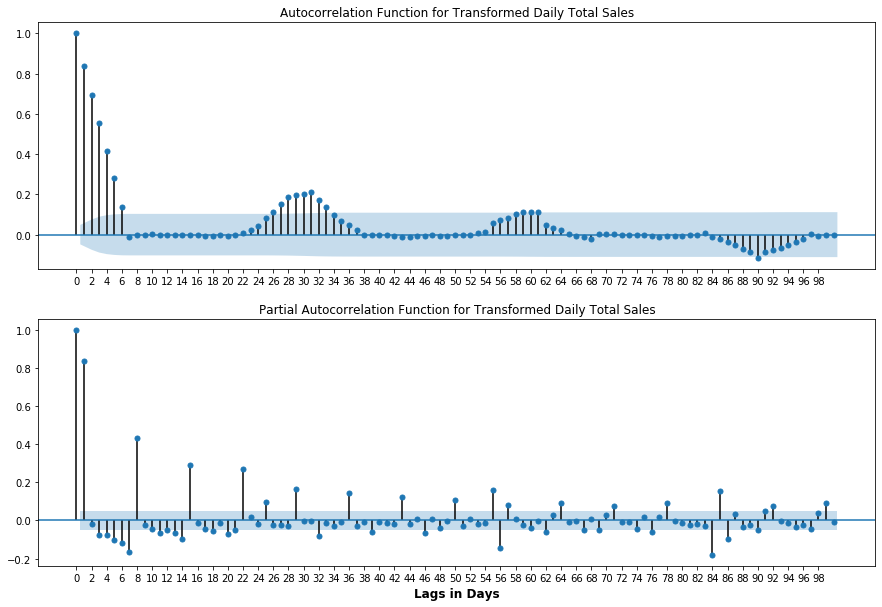

In [135]:
'''Setting up the log transformed and differenced timeseries of daily sales across all stores. This step is the
result of the exploratory data analysis.'''

dailysales = np.log(train.loc[trg_idx].groupby('date')['sales'].sum()).diff(7)
dailysales = dailysales.dropna()

# Explicitly setting the DatetimeIndex frequency
dailysales.index = pd.DatetimeIndex(dailysales.index.values, freq = 'D')

fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize = (15, 10))

tsaplots.plot_acf(dailysales, ax = ax1, alpha = 0.05, lags = 100, 
                  title = 'Autocorrelation Function for Transformed Daily Total Sales')
tsaplots.plot_pacf(dailysales, ax = ax2, alpha = 0.05, lags = 100,
                   title = 'Partial Autocorrelation Function for Transformed Daily Total Sales')

ax1.set_xticks(np.arange(0, 100, 2))
ax2.set_xticks(np.arange(0, 100, 2))
ax2.set_xlabel('Lags in Days', fontsize = '12', fontweight = 'bold')

plt.show()

### SARIMA Model Parameters - Grid Search

The exploratory data analysis helps us set up the following grid for the transformed timeseries:
<ol>
    <li>MA params: p = 1, 2, 3, 4, 5, 6 and P = 0,
    <li>AR params: q = 1, 2, 3, 4, 5, 6, 7, 8 and Q = 1
    <li>d = D = 0, since we have already differenced the series, and
    <li>s = 7
</ol>

In [139]:
# Set the parameter grid
p = range(1, 7)
d = range(0, 1)
q = range(1, 7)
P = range(0, 1)
D = range(0, 1)
Q = range(1, 2)
s = range(7, 8)

# Forming the grid
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))

# SARIMA model pipeline
for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            model = SARIMAX(dailysales, order = param, seasonal_order = seasonal_param)
            results = model.fit(method = 'powell')
            print('SARIMA{},{} - AIC:{}'.format(param, seasonal_param, results.aic))
        except:
            continue


Optimization terminated successfully.
         Current function value: -2.212770
         Iterations: 7
         Function evaluations: 361
SARIMA(1, 0, 1),(0, 0, 1, 7) - AIC:-7232.181961743156
Optimization terminated successfully.
         Current function value: -2.212731
         Iterations: 7
         Function evaluations: 436
SARIMA(1, 0, 2),(0, 0, 1, 7) - AIC:-7230.057414924347
Optimization terminated successfully.
         Current function value: -2.212643
         Iterations: 7
         Function evaluations: 510
SARIMA(1, 0, 3),(0, 0, 1, 7) - AIC:-7227.769297864255
Optimization terminated successfully.
         Current function value: -2.212517
         Iterations: 10
         Function evaluations: 868
SARIMA(1, 0, 4),(0, 0, 1, 7) - AIC:-7225.356631113233
Optimization terminated successfully.
         Current function value: -2.212667
         Iterations: 12
         Function evaluations: 1141
SARIMA(1, 0, 5),(0, 0, 1, 7) - AIC:-7223.847987444706
Optimization terminated successf

Best results: SARIMA(1, 0, 6) x (0, 0, 1, 7) - AIC: -7242.780603227922

In [ ]:
train_len = np.int(0.9*len(tot_sls_trans))
train_tot_sls_trans = tot_sls_trans[:train_len]
test_tot_sls_trans = tot_sls_trans[train_len:]

In [ ]:
# Set the implied frequency of the timeseries to suppress a subsequent warning by SARIMAX()
dailysales_all.index = pd.DatetimeIndex(dailysales_all.index.values, 
                                           freq=dailysales_all.index.inferred_freq)

model = SARIMAX(dailysales_all, order = (1, 1, 1), seasonal_order = (1, 1, 1, 7), 
                trend = 'n').fit(method = 'powell')
res = model.resid

display(model.summary())

fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize = (13, 9), sharex = True)

tsaplots.plot_pacf(res, ax = ax1, 
                   title = 'Partial Autocorrelation Function for Residues')

tsaplots.plot_acf(res, ax = ax2,
                  title = 'Autocorrelation Function for Residues')
ax2.set_xticks(np.arange(0, 36))
ax2.set_xlabel('Lags in Days', fontsize = '12', fontweight = 'bold')

plt.show()